<a href="https://colab.research.google.com/github/AlexanderVieira/training_datascience/blob/main/UBER_GPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/dima42/uber-gps-analysis/master/gpsdata/all.tsv"

data = pd.read_csv(url, sep="\t", header=None)
data.columns = ["car", "utc date", "lat", "lng"]
data["utc date"] = pd.to_datetime(data["utc date"])

In [ ]:
data

,car,utc date,lat,lng
0,1,2007-01-07 10:54:50+00:00,37.782551,-122.445368
1,1,2007-01-07 10:54:54+00:00,37.782745,-122.444586
2,1,2007-01-07 10:54:58+00:00,37.782842,-122.443688
3,1,2007-01-07 10:55:02+00:00,37.782919,-122.442815
4,1,2007-01-07 10:55:06+00:00,37.782992,-122.442112
...,...,...,...,...
1128658,25000,2007-01-06 02:37:56+00:00,37.766183,-122.429307
1128659,25000,2007-01-06 02:38:28+00:00,37.766136,-122.429508
1128660,25000,2007-01-06 02:38:32+00:00,37.766115,-122.429704
1128661,25000,2007-01-06 02:38:36+00:00,37.766105,-122.429869


# Convert to NYC timezone

In [ ]:
import pytz

In [ ]:
utc = pytz.utc
eastern = pytz.timezone("US/Eastern")

data["date"] = data["utc date"].apply(lambda dt: dt.astimezone(eastern))

# Identify pickups 

In [ ]:
data.sort_values(["car", "date"], inplace=True)
data.reset_index(drop=True, inplace=True)


## Calculate the interval column

In [ ]:
interval = list((data.iloc[1:,:].date.values - data.iloc[0:-1,:].date.values).astype(int) / 1e9)
interval = [0] + interval
data["Interval"] = interval
selector = [True] + (data.iloc[1:,0].values != data.iloc[0:-1,0].values).tolist()
data.loc[selector, "Interval"] = 0.0


In [ ]:
!pip install dtale 2>&1 >> /dev/null


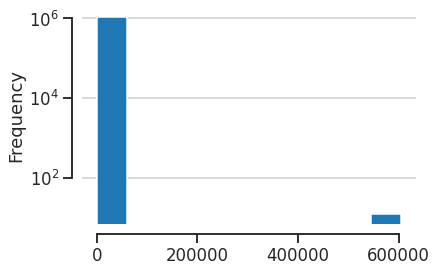

In [ ]:
import seaborn as sns
import numpy as np
sns.set_style("ticks")
sns.set_context("talk")

ax = data[data.Interval != 0 ].Interval.plot(kind="hist")
ax.set_yscale("log")
ax.yaxis.grid(True)
sns.despine(offset=10, trim=True)

# Remove cars with long idle times (Bad Quality Data)

In [ ]:
idle_threshold = 3600 #s // 3600 s == 1 hour

bad_quality_cars = data[data.Interval > idle_threshold].car.unique()
bad_quality_cars

array([  272,  5743,  7048,  7444, 12446, 13813, 13869, 15566, 15710,
       15901, 17577, 24593])

In [ ]:
data = data[~data.car.isin(bad_quality_cars)]
data.reset_index(drop=True, inplace=True)

In [ ]:
data

,car,utc date,lat,lng,date,Interval
0,1,2007-01-07 10:54:50+00:00,37.782551,-122.445368,2007-01-07 05:54:50-05:00,0.0
1,1,2007-01-07 10:54:54+00:00,37.782745,-122.444586,2007-01-07 05:54:54-05:00,4.0
2,1,2007-01-07 10:54:58+00:00,37.782842,-122.443688,2007-01-07 05:54:58-05:00,4.0
3,1,2007-01-07 10:55:02+00:00,37.782919,-122.442815,2007-01-07 05:55:02-05:00,4.0
4,1,2007-01-07 10:55:06+00:00,37.782992,-122.442112,2007-01-07 05:55:06-05:00,4.0
...,...,...,...,...,...,...
1128077,25000,2007-01-06 02:37:56+00:00,37.766183,-122.429307,2007-01-05 21:37:56-05:00,4.0
1128078,25000,2007-01-06 02:38:28+00:00,37.766136,-122.429508,2007-01-05 21:38:28-05:00,32.0
1128079,25000,2007-01-06 02:38:32+00:00,37.766115,-122.429704,2007-01-05 21:38:32-05:00,4.0
1128080,25000,2007-01-06 02:38:36+00:00,37.766105,-122.429869,2007-01-05 21:38:36-05:00,4.0


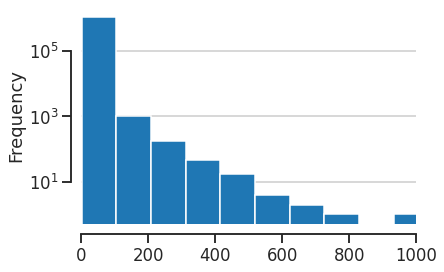

In [ ]:
sns.set_style("ticks")
sns.set_context("talk")

ax = data[data.Interval != 0 ].Interval.plot(kind="hist")
ax.set_yscale("log")
ax.set_xlim([0, 1000])
ax.yaxis.grid(True)
sns.despine(offset=10, trim=True)

In [ ]:
#import dtale
#import dtale.app as dtale_app

#dtale_app.USE_COLAB = True
#dtale.show(data[data.car == 272])

# Create heatmap

In [ ]:

heat_data = data.sample(65000)[["lat", "lng"]].values.tolist()

In [ ]:
import folium 

from folium.plugins import HeatMap
map = folium.Map(location=[37.8, -122.43])


# plot heatmap
map.add_child(HeatMap(heat_data, radius=20))

map